In [1]:
from __future__ import print_function
import os
from itertools import izip, islice
from collections import defaultdict

import readability
import requests
from gutenberg import cleanup

import pandas as pd
from pandas import DataFrame

In [2]:
%matplotlib inline

# Readability

[readability 0.1 : Python Package Index](https://pypi.python.org/pypi/readability/0.1)

```
pip install https://github.com/andreasvc/readability/tarball/master
pip install Gutenberg
```

https://github.com/c-w/Gutenberg/blob/master/gutenberg/cleanup/strip_headers.py

* Kincaid: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch.E2.80.93Kincaid_grade_level and https://github.com/andreasvc/readability/blob/v0.1/readability/__init__.py#L118
* SMOG: https://en.wikipedia.org/wiki/SMOG and https://github.com/andreasvc/readability/blob/v0.1/readability/__init__.py#L143

In [3]:
# Moby Dick

url = "https://github.com/GITenberg/Moby-Dick--Or-The-Whale_2701/raw/master/2701.txt"
text = cleanup.strip_headers(requests.get(url).text)
text[:100], text[-100:]

(u"\n\n\n\n\nMOBY DICK; OR THE WHALE\n\nBy Herman Melville\n\n\n\n\nOriginal Transcriber's Notes:\n\nThis text is a c",
 u'ing Rachel, that in\nher retracing search after her missing children, only found another\norphan.\n\n\n\n\n')

In [4]:
moby_readability = readability.getmeasures(text, lang='en')

In [5]:
moby_readability.get('sentence info').get('characters'), moby_readability.get('sentence info').get('words')

(957565, 215173)

In [6]:
moby_readability['readability grades'].get('SMOGIndex'), moby_readability['readability grades'].get('Kincaid')

(8.771045094479767, 5.190075975866268)

# Read the data file with list of GITenberg repositories and text files

In [7]:
# you can get the GITenberg_repos_list_2.tsv from https://gist.github.com/rdhyee/3c9195d639223ce5e4c7
# https://gist.githubusercontent.com/rdhyee/3c9195d639223ce5e4c7/raw/GITenberg_repos_list_2.tsv

if not os.stat("GITenberg_repos_list_2.tsv"):
    DATAFILE_URL = "https://gist.githubusercontent.com/rdhyee/3c9195d639223ce5e4c7/raw/GITenberg_repos_list_2.tsv"
    with open("GITenberg_repos_list_2.tsv", "wb") as f:
        f.write(requests.get(DATAFILE_URL).content)

df = pd.read_csv("GITenberg_repos_list_2.tsv", sep="\t", encoding="UTF-8")

In [8]:
def classify_text_files(g_id, files):
    """
    put into buckets: .txt, -0.txt, -5.txt, -8.txt, other
    """
    
    # https://www.gutenberg.org/files/
    bucket_labels = [('ascii', "{g_id}.txt"),
                     ('utf-8', "{g_id}-0.txt"),
                     ('8-bit', "{g_id}-8.txt"), # iso-8859-1, windows-1252, MacRoman, ...
                     ('big5',  "{g_id}-5.txt")
                    ]
    
    buckets = defaultdict(list) # make values list to be consistent
    files_set = set(files)
    
    for (label, template) in bucket_labels:
        f_name = template.format(g_id=g_id)
        if f_name in files_set:
            buckets[label].append(f_name)
            files_set.remove(f_name)
            
    # pick up rest      
    if files_set:
        buckets['other'] = list(files_set)
    
    return buckets.items()  
    
# https://raw.githubusercontent.com/GITenberg/Little-Dorrit_963/master/963.txt

def gitenberg_url(title, text_file):
    return "https://raw.githubusercontent.com/GITenberg/{title}/master/{text_file}".format(title=title,
                                                                                          text_file=text_file)

# any other in the form of (\d+)-(\d).txt or \(d+).txt?

def unexpected_other(files):
    """files whose file namelooks suspicious """
    import re

    if files is None:
        return False
    
    for f in files:
        if re.search(r'^(\d+)-(\d).txt$', f) or re.search(r'^(\d+).txt$', f):
            return True
    
    return False

# compute URL for a text file

def gitenberg_raw_url(repo_name, file_name, branch='master'):
    if file_name is not None:
        return "https://raw.githubusercontent.com/GITenberg/{repo_name}/{branch}/{file_name}".format(repo_name=repo_name,
                                                                                                file_name=file_name,
                                                                                                branch=branch)
    else:
        return None

    
# for a given repository, return URL for "best" file to work with
#preference:  utf-8, ascii, big5, 8-bit (because of ambiguity)
# if unicode available, return it and encoding

def preferred_file(files_d):
    PREF_ORDER = ['utf-8', 'ascii', 'big5', '8-bit']
    for f_type in PREF_ORDER:
        files_of_type = files_d.get(f_type)
        if files_of_type:
            return (files_of_type[0], f_type)
        
    return (None, None)

# HTTP HEAD on the file
def http_head_status(url):
    import requests
    
    if url is not None:
        r = requests.head(url)
        return r.status_code
    else:
        return None

In [9]:
# what about those multiple txt
df.text_files = df.text_files.map(lambda s: [f.strip() for f in s[1:-1].split(",") if len(f) and not f.isspace()])

In [10]:
df['files_by_encoding'] = df.apply(lambda r:classify_text_files(r.gitb_id, r.text_files), axis=1).map(dict)

In [11]:
# study 'other'
df['other'] = df.files_by_encoding.map(lambda d: d.get('other'))

In [12]:
# hmmm...these files deserve a closer look
df[df.other.map(unexpected_other)][['gitb_id','other','text_files']]

,gitb_id,other,text_files
3041,11052,[11502-8.txt],"[11502-8.txt, 11052.txt, 11052-8.txt]"
4734,37985,[37895-8.txt],"[37985.txt, 37895-8.txt, 37985-0.txt]"
7176,20915,[20015.txt],"[20915-8.txt, 20015.txt]"
11948,3198,"[3189-8.txt, 3189.txt]","[3189-8.txt, 3189.txt, 3198.txt]"
12293,36084,[36086-8.txt],"[36086-8.txt, 36084-0.txt]"
27517,5964,[5694-8.txt],"[5964.txt, 5964-8.txt, 5694-8.txt]"
34856,38494,[38535-0.txt],"[38494-0.txt, 38535-0.txt]"


In [13]:
df['preferred_file'] = df.files_by_encoding.map(preferred_file)

In [14]:
df.head()

,Unnamed: 0,gitb_id,gitb_name,title,language,downloads,text_files,files_by_encoding,other,preferred_file
0,3881,1342,Pride-and-Prejudice_1342,Pride and Prejudice,en,39054,[1342.txt],{u'ascii': [u'1342.txt']},None,"(1342.txt, ascii)"
1,2258,11,Alice-s-Adventures-in-Wonderland_11,Alice's Adventures in Wonderland,en,27037,[11.txt],{u'ascii': [u'11.txt']},None,"(11.txt, ascii)"
2,19931,27827,The-Kama-Sutra-of-Vatsyayana--13-Translated-Fr...,The Kama Sutra of Vatsyayana\nTranslated From ...,en,19610,"[27827-8.txt, 27827.txt]","{u'8-bit': [u'27827-8.txt'], u'ascii': [u'2782...",None,"(27827.txt, ascii)"
3,46905,76,Adventures-of-Huckleberry-Finn_76,Adventures of Huckleberry Finn,en,17799,[76.txt],{u'ascii': [u'76.txt']},None,"(76.txt, ascii)"
4,46682,74,The-Adventures-of-Tom-Sawyer_74,The Adventures of Tom Sawyer,en,17767,[74.txt],{u'ascii': [u'74.txt']},None,"(74.txt, ascii)"


In [15]:
df['preferred_text_url'] = df.apply(lambda row: gitenberg_raw_url(row.gitb_name, row.preferred_file[0]), axis=1)

In [16]:
df[:5].preferred_text_url.map(http_head_status)

0    200
1    200
2    200
3    200
4    200
Name: preferred_text_url, dtype: int64

In [17]:
# decorator that returns a tuple with args and return value

def also_arg(func):
    """
    for use for single-argument function
    """
    def wrapper(arg, label=None):
        try:
            result = func(arg)
        except Exception, e:
            result = e
            
        return {'arg':arg, 'result':result, 'label':label}
    
    return wrapper

In [18]:
# http://chriskiehl.com/article/parallelism-in-one-line/
from __future__ import print_function
from multiprocessing import Pool as ProcessPool
from multiprocessing.dummy import Pool as ThreadPool 
from functools import partial
from itertools import islice

from math import factorial

# http://stackoverflow.com/questions/2348317/how-to-write-a-pager-for-python-iterators/2350904#2350904        
def grouper(iterable, page_size):
    page= []
    for item in iterable:
        page.append( item )
        if len(page) == page_size:
            yield page
            page= []
    if len(page) > 0:
        yield page


#get_key_sizes_for_bucket = partial(get_key_sizes, bucket_name="aws-publicdatasets")

PAGE_SIZE = 10
POOL_SIZE = 8
MAX_SEGMENTS = 5 # replace with None for all segments
CHUNK_SIZE = 10

pool = ThreadPool(POOL_SIZE)  # or ThreadPool
results_iter = pool.imap_unordered(lambda x:also_arg(factorial)(x, label="job:{0}".format(x)), 
                              xrange(-1,MAX_SEGMENTS),
                              CHUNK_SIZE)

results = []
                             
for (i, result) in enumerate(islice(results_iter,None)):
    print ('\r>> Result %d' % i, end="")
    results.append(result)
            

>> Result 5

In [19]:
results

[{'arg': -1,
  'label': 'job:-1',
  'result': ValueError('factorial() not defined for negative values')},
 {'arg': 0, 'label': 'job:0', 'result': 1},
 {'arg': 1, 'label': 'job:1', 'result': 1},
 {'arg': 2, 'label': 'job:2', 'result': 2},
 {'arg': 3, 'label': 'job:3', 'result': 6},
 {'arg': 4, 'label': 'job:4', 'result': 24}]

# calculate HTTP HEAD status

In [20]:
#get_key_sizes_for_bucket = partial(get_key_sizes, bucket_name="aws-publicdatasets")

PAGE_SIZE = 10
POOL_SIZE = 4
MAX_SEGMENTS = 20 # replace with None for all segments
CHUNK_SIZE = 10

pool = ThreadPool(POOL_SIZE)  # or ThreadPool
results_iter = pool.imap_unordered(lambda x: also_arg(http_head_status)(x[1],label=x[0]), 
                              df[:MAX_SEGMENTS].apply(lambda r: (r.gitb_id,r.preferred_text_url), axis=1),
                              CHUNK_SIZE)

results = []
                             
for (i, result) in enumerate(islice(results_iter,None)):
    print ('\r>> Result %d' % i, end="")
    results.append(result)

>> Result 19

In [21]:
results

[{'arg': 'https://raw.githubusercontent.com/GITenberg/Pride-and-Prejudice_1342/master/1342.txt',
  'label': 1342,
  'result': 200},
 {'arg': 'https://raw.githubusercontent.com/GITenberg/Alice-s-Adventures-in-Wonderland_11/master/11.txt',
  'label': 11,
  'result': 200},
 {'arg': 'https://raw.githubusercontent.com/GITenberg/The-Kama-Sutra-of-Vatsyayana--13-Translated-From-the-Sanscrit-in-Seven-Parts-With-Preface-Int__27827/master/27827.txt',
  'label': 27827,
  'result': 200},
 {'arg': 'https://raw.githubusercontent.com/GITenberg/Adventures-of-Huckleberry-Finn_76/master/76.txt',
  'label': 76,
  'result': 200},
 {'arg': 'https://raw.githubusercontent.com/GITenberg/The-Adventures-of-Tom-Sawyer_74/master/74.txt',
  'label': 74,
  'result': 200},
 {'arg': 'https://raw.githubusercontent.com/GITenberg/The-Yellow-Wallpaper_1952/master/1952.txt',
  'label': 1952,
  'result': 200},
 {'arg': 'https://raw.githubusercontent.com/GITenberg/Ulysses_4300/master/4300.txt',
  'label': 4300,
  'result': 

In [22]:
# write a function to take a url and returns readability of the text at URL

def readability_of_text(url):

    text = cleanup.strip_headers(requests.get(url).text)
    return readability.getmeasures(text, lang='en')
        

In [23]:
POOL_SIZE = 4
MAX_SEGMENTS = 100 # replace with None for all segments
CHUNK_SIZE = 10

pool = ThreadPool(POOL_SIZE)  # or ThreadPool
results_iter = pool.imap_unordered(lambda x: also_arg(readability_of_text)(x[1],label=x[0]), 
                              df[df.language=='en'][:MAX_SEGMENTS].apply(lambda r: (r.gitb_id,r.preferred_text_url), axis=1),
                              CHUNK_SIZE)

results = []
                             
for (i, result) in enumerate(islice(results_iter,None)):
    print ('\r>> Result %d' % i, end="")
    results.append(result)

>> Result 99

In [24]:
r_df = DataFrame(results)
r_df.head()

,arg,label,result
0,https://raw.githubusercontent.com/GITenberg/A-...,1080,{u'readability grades': {u'Kincaid': 5.8586680...
1,https://raw.githubusercontent.com/GITenberg/A-...,1080,{u'readability grades': {u'Kincaid': 5.8586680...
2,https://raw.githubusercontent.com/GITenberg/Du...,2814,{u'readability grades': {u'Kincaid': 3.8474982...
3,https://raw.githubusercontent.com/GITenberg/Ja...,1260,{u'readability grades': {u'Kincaid': 4.3493942...
4,https://raw.githubusercontent.com/GITenberg/Ja...,1260,{u'readability grades': {u'Kincaid': 4.3508467...


In [25]:
r_df['exception'] = r_df.result.map(lambda r: isinstance(r, Exception))

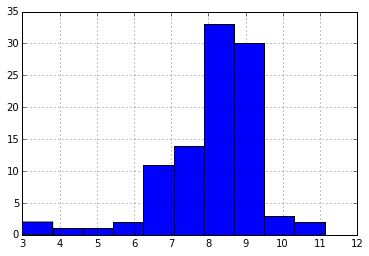

In [26]:
r_df[~r_df.exception].result.map(lambda r: r['readability grades'].get('SMOGIndex')).hist()

In [27]:
df['SMOGIndex'] = r_df[~r_df.exception].result.map(lambda r: r['readability grades'].get('SMOGIndex'))

In [28]:
df[~df.SMOGIndex.isnull()][['title','SMOGIndex']].sort(columns='SMOGIndex')

,title,SMOGIndex
93,"The Awakening, and Selected Short Stories",3.000000
81,The King James Version of the Bible,3.000000
97,The Art of War,4.131155
69,The Time Machine,4.976849
84,Complete Original Short Stories of Guy De Maup...,5.982258
37,Siddhartha,6.166544
47,Novo dicionário da língua portuguesa,6.581048
95,Essays of Michel de Montaigne — Complete,6.612771
13,The Importance of Being Earnest: A Trivial Com...,6.662959
24,"Frankenstein; Or, The Modern Prometheus",6.727013


In [ ]:
# alternative way to get Gutenberg texts
# calculate the URI
# https://github.com/c-w/Gutenberg/blob/PyPI-0.4/gutenberg/acquire/text.py#L19

from gutenberg import acquire
acquire.text._format_download_uri(2701)